# Описание обучения

### Данные

1. Берутся только id героев как фичи
2. id героев вытягиваются в некоторые фичи героев

### Обучение

1. Для **ML подходов:** \
Конкатинируются в вектор длины $ 2 * len(heroFeatures) $ \
Для Radiant - $ len(heroFeatures) $ \
Для Dire - $ len(heroFeatures) $

2. Для **DL подходов:** ?

In [1]:
base_path = '/Users/ankamenskiy/SmartDota/'

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(base_path)

# import sys
# sys.path.append('../../..')

In [3]:
!pwd

/Users/ankamenskiy/SmartDota/src/experiments/ids_to_hero-stats


In [4]:
import pickle
import dataclasses
import json

import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt

from src.data.api.OpenDota.pro_matches_dataloader import ProMatchesDataloader
from src.data.api.OpenDota.public_matches_dataloader import PublicMatchesDataloader

import itertools

from sklearn.preprocessing import MultiLabelBinarizer

## Читаем данные

In [5]:
train_path = base_path +'cache/public_110000_7-34b-ALL'
# test_path = base_path +'cache/pro_10000_dups_light'
test_path = base_path +'cache/pro_10000_dups'

train_dataloader = PublicMatchesDataloader(0, 0)
train_dataloader.load(path=train_path)
test_dataloader = ProMatchesDataloader()
test_dataloader.load(path=test_path)

train_data = train_dataloader.data
test_data = test_dataloader.data

print(len(train_data), len(test_data))

Empty Key
Last match index: 7504377105
Last match index: 7502042193
110000 10000


In [11]:
# Create a custom JSON encoder for dataclasses
class DataclassEncoder(json.JSONEncoder):
    def default(self, obj):
        if dataclasses.is_dataclass(obj):
            return {
                "__dataclass__": obj.__class__.__name__,
                "fields": dataclasses.asdict(obj)
            }
        return super().default(obj)

# Get the dataclass instance
match_data = test_data[100]

# Convert to dictionary with dataclass metadata
match_dict = {
    "fields": dataclasses.asdict(match_data)
}
match_dict['fields'].pop('teamfights') # hz
match_dict['fields'].pop('objectives') # when towers got destroyed
match_dict['fields'].pop('players') # players actions during the match

# Save to file with pretty printing
with open('match_data.json', 'w') as f:
    json.dump(match_dict, f, indent=2, cls=DataclassEncoder)

# Print the saved data
print(f"Saved match data to match_data.json")

Saved match data to match_data.json


In [11]:
import json
import dataclasses

d = dataclasses.asdict(test_data[0])

with open('a.json', 'w') as f:
    f.write(json.dumps(d))

## Готовим датасет

### For PUBLIC matches [TRAIN data]

In [12]:
df_train_val = pd.DataFrame()

df_train_val['target'] = [1 if match.radiant_win else 0 for match in train_data]
df_train_val['radiant_hero_ids'] = [match.radiant_team for match in train_data]
df_train_val['dire_hero_ids'] = [match.dire_team for match in train_data]

df_train_val.dropna(inplace=True)
display(df_train_val)
df_train_val.groupby('target')['target'].count()

,target,radiant_hero_ids,dire_hero_ids
0,1,"[39, 136, 105, 72, 113]","[53, 31, 7, 97, 95]"
1,1,"[96, 9, 48, 106, 31]","[64, 89, 34, 123, 135]"
2,0,"[49, 129, 113, 64, 20]","[94, 33, 29, 112, 37]"
3,0,"[105, 123, 93, 106, 57]","[137, 26, 65, 47, 18]"
4,1,"[129, 8, 21, 136, 26]","[53, 14, 6, 20, 137]"
...,...,...,...
95730,1,"[102, 87, 71, 18, 65]","[106, 83, 15, 62, 69]"
95731,0,"[74, 138, 84, 87, 86]","[90, 41, 101, 26, 96]"
95738,1,"[20, 53, 128, 32, 46]","[119, 45, 70, 28, 106]"
95739,1,"[41, 74, 71, 64, 60]","[97, 110, 114, 86, 111]"


target
0    45230
1    50499
Name: target, dtype: int64

### For PRO matches [TEST data]

0 - Radiant \
1 - Dire

In [13]:
pb = [elem.picks_bans for elem in test_data]

radiants, dires, targets = [], [], []

for i, elem in enumerate(test_data):
    pb = elem.picks_bans
    target = elem.pro_match_data.radiant_win # 1 if RADIANT win | 0 if DIRE win

    if pb is None or target is None:
        continue
    
    pb = sorted(filter(lambda x: x.is_pick, pb), key=lambda x: x.team)
    assert len(pb) == 10

    radiants.append([e.hero_id for e in pb[:5]])
    dires.append([e.hero_id for e in pb[5:]])
    targets.append(int(target))

df_test = pd.DataFrame()

df_test['target'] = targets
df_test['radiant_hero_ids'] = radiants
df_test['dire_hero_ids'] = dires

display(df_test)
display(df_test.isna().sum())
df_test.groupby('target')['target'].count()

,target,radiant_hero_ids,dire_hero_ids
0,0,"[20, 114, 120, 92, 48]","[121, 126, 21, 105, 135]"
1,1,"[20, 110, 16, 36, 76]","[53, 128, 70, 106, 129]"
2,1,"[90, 79, 29, 12, 25]","[49, 9, 105, 93, 50]"
3,0,"[49, 45, 37, 126, 84]","[123, 79, 96, 41, 61]"
4,0,"[105, 5, 13, 96, 70]","[121, 49, 19, 54, 21]"
...,...,...,...
9903,1,"[27, 70, 65, 29, 11]","[85, 96, 26, 1, 43]"
9904,1,"[69, 26, 51, 21, 120]","[58, 49, 86, 1, 22]"
9905,0,"[56, 20, 98, 95, 120]","[66, 61, 86, 70, 13]"
9906,1,"[129, 45, 51, 46, 17]","[68, 26, 67, 14, 19]"


target              0
radiant_hero_ids    0
dire_hero_ids       0
dtype: int64

target
0    4767
1    5141
Name: target, dtype: int64

### Heroes statistics

In [17]:
hero_stats_path = base_path + 'data/hero_stats.json'

id_to_hs = {}
with open(hero_stats_path, 'r') as f:
    hs = json.loads(f.read())
    [id_to_hs.setdefault(h['id'], h) for h in hs]

In [30]:
def make_hero_onehot(df):
    mlb = MultiLabelBinarizer(sparse_output=True)
    df = df.copy()

    df1 = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop('radiant_hero_ids')),
                index=df.index,
                columns=mlb.classes_
            )
        )
    df2 = df1.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df1.pop('dire_hero_ids')),
                index=df1.index,
                columns=mlb.classes_
            ),
            lsuffix='_radiant', 
            rsuffix='_dire'
        )
    return df2


def add_extra_features(df):

    result_columns = [[
        col + '_pro_winrate',
        # col + '_pro_win',
        # col + '_pro_pick',
        col + '_pro_ban',
        col + '_pub_winrate',
        # col + '_pub_win',
        # col + '_pub_pick'
    ] if col != 'target' else ['target']
    for col in df.columns]
    result_columns = list(itertools.chain(*result_columns))

    result_values = []
    for _, row in df.iterrows():
        row_values = []
        for col in df.columns:
            if col == 'target':
                row_values.append(row['target'])
            elif row[col] == 0:
                row_values.extend([0, 0, 0])
            else:
                hero_id = int(col.split('_')[0])
                hero_stats = id_to_hs[hero_id]

                row_values.extend([
                    hero_stats['pro_win'] / hero_stats['pro_pick'],
                    hero_stats['pro_ban'] / hero_stats['pro_pick'],
                    hero_stats['pub_win'] / hero_stats['pub_pick']
                ])
        result_values.append(row_values)

    return pd.DataFrame(result_values, columns=result_columns) #, dtype=int)


df_train_val_extended = make_hero_onehot(df_train_val).drop_duplicates()
df_test_extended = make_hero_onehot(df_test).drop_duplicates()
display(df_train_val_extended)
display(df_test_extended)

df_train_val_extended = add_extra_features(df_train_val_extended)
df_test_extended = add_extra_features(df_test_extended)
display(df_train_val_extended)
display(df_test_extended)

,target,1_radiant,2_radiant,3_radiant,4_radiant,5_radiant,6_radiant,7_radiant,8_radiant,9_radiant,10_radiant,11_radiant,12_radiant,13_radiant,14_radiant,15_radiant,16_radiant,17_radiant,18_radiant,19_radiant,20_radiant,21_radiant,22_radiant,23_radiant,25_radiant,26_radiant,27_radiant,28_radiant,29_radiant,30_radiant,31_radiant,32_radiant,33_radiant,34_radiant,35_radiant,36_radiant,37_radiant,38_radiant,39_radiant,40_radiant,41_radiant,42_radiant,43_radiant,44_radiant,45_radiant,46_radiant,47_radiant,48_radiant,49_radiant,50_radiant,51_radiant,52_radiant,53_radiant,54_radiant,55_radiant,56_radiant,57_radiant,58_radiant,59_radiant,60_radiant,61_radiant,62_radiant,63_radiant,64_radiant,65_radiant,66_radiant,67_radiant,68_radiant,69_radiant,70_radiant,71_radiant,72_radiant,73_radiant,74_radiant,75_radiant,76_radiant,77_radiant,78_radiant,79_radiant,80_radiant,81_radiant,82_radiant,83_radiant,84_radiant,85_radiant,86_radiant,87_radiant,88_radiant,89_radiant,90_radiant,91_radiant,92_radiant,93_radiant,94_radiant,95_radiant,96_radiant,97_radiant,98_radiant,99_radiant,100_radiant,101_radiant,102_radiant,103_radiant,104_radiant,105_radiant,106_radiant,107_radiant,108_radiant,109_radiant,110_radiant,111_radiant,112_radiant,113_radiant,114_radiant,119_radiant,120_radiant,121_radiant,123_radiant,126_radiant,128_radiant,129_radiant,135_radiant,136_radiant,137_radiant,138_radiant,1_dire,2_dire,3_dire,4_dire,5_dire,6_dire,7_dire,8_dire,9_dire,10_dire,11_dire,12_dire,13_dire,14_dire,15_dire,16_dire,17_dire,18_dire,19_dire,20_dire,21_dire,22_dire,23_dire,25_dire,26_dire,27_dire,28_dire,29_dire,30_dire,31_dire,32_dire,33_dire,34_dire,35_dire,36_dire,37_dire,38_dire,39_dire,40_dire,41_dire,42_dire,43_dire,44_dire,45_dire,46_dire,47_dire,48_dire,49_dire,50_dire,51_dire,52_dire,53_dire,54_dire,55_dire,56_dire,57_dire,58_dire,59_dire,60_dire,61_dire,62_dire,63_dire,64_dire,65_dire,66_dire,67_dire,68_dire,69_dire,70_dire,71_dire,72_dire,73_dire,74_dire,75_dire,76_dire,77_dire,78_dire,79_dire,80_dire,81_dire,82_dire,83_dire,84_dire,85_dire,86_dire,87_dire,88_dire,89_dire,90_dire,91_dire,92_dire,93_dire,94_dire,95_dire,96_dire,97_dire,98_dire,99_dire,100_dire,101_dire,102_dire,103_dire,104_dire,105_dire,106_dire,107_dire,108_dire,109_dire,110_dire,111_dire,112_dire,113_dire,114_dire,119_dire,120_dire,121_dire,123_dire,126_dire,128_dire,129_dire,135_dire,136_dire,137_dire,138_dire
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

,target,1_radiant,2_radiant,3_radiant,4_radiant,5_radiant,6_radiant,7_radiant,8_radiant,9_radiant,10_radiant,11_radiant,12_radiant,13_radiant,14_radiant,15_radiant,16_radiant,17_radiant,18_radiant,19_radiant,20_radiant,21_radiant,22_radiant,23_radiant,25_radiant,26_radiant,27_radiant,28_radiant,29_radiant,30_radiant,31_radiant,32_radiant,33_radiant,34_radiant,35_radiant,36_radiant,37_radiant,38_radiant,39_radiant,40_radiant,41_radiant,42_radiant,43_radiant,44_radiant,45_radiant,46_radiant,47_radiant,48_radiant,49_radiant,50_radiant,51_radiant,52_radiant,53_radiant,54_radiant,55_radiant,56_radiant,57_radiant,58_radiant,59_radiant,60_radiant,61_radiant,62_radiant,63_radiant,64_radiant,65_radiant,66_radiant,67_radiant,68_radiant,69_radiant,70_radiant,71_radiant,72_radiant,73_radiant,74_radiant,75_radiant,76_radiant,77_radiant,78_radiant,79_radiant,80_radiant,81_radiant,82_radiant,83_radiant,84_radiant,85_radiant,86_radiant,87_radiant,88_radiant,89_radiant,90_radiant,91_radiant,92_radiant,93_radiant,94_radiant,95_radiant,96_radiant,97_radiant,98_radiant,99_radiant,100_radiant,101_radiant,102_radiant,103_radiant,104_radiant,105_radiant,106_radiant,107_radiant,108_radiant,109_radiant,110_radiant,111_radiant,112_radiant,113_radiant,114_radiant,119_radiant,120_radiant,121_radiant,123_radiant,126_radiant,128_radiant,129_radiant,135_radiant,136_radiant,137_radiant,138_radiant,1_dire,2_dire,3_dire,4_dire,5_dire,6_dire,7_dire,8_dire,9_dire,10_dire,11_dire,12_dire,13_dire,14_dire,15_dire,16_dire,17_dire,18_dire,19_dire,20_dire,21_dire,22_dire,23_dire,25_dire,26_dire,27_dire,28_dire,29_dire,30_dire,31_dire,32_dire,33_dire,34_dire,35_dire,36_dire,37_dire,38_dire,39_dire,40_dire,41_dire,42_dire,43_dire,44_dire,45_dire,46_dire,47_dire,48_dire,49_dire,50_dire,51_dire,52_dire,53_dire,54_dire,55_dire,56_dire,57_dire,58_dire,59_dire,60_dire,61_dire,62_dire,63_dire,64_dire,65_dire,66_dire,67_dire,68_dire,69_dire,70_dire,71_dire,72_dire,73_dire,74_dire,75_dire,76_dire,77_dire,78_dire,79_dire,80_dire,81_dire,82_dire,83_dire,84_dire,85_dire,86_dire,87_dire,88_dire,89_dire,90_dire,91_dire,92_dire,93_dire,94_dire,95_dire,96_dire,97_dire,98_dire,99_dire,100_dire,101_dire,102_dire,103_dire,104_dire,105_dire,106_dire,107_dire,108_dire,109_dire,110_dire,111_dire,112_dire,113_dire,114_dire,119_dire,120_dire,121_dire,123_dire,126_dire,128_dire,129_dire,135_dire,136_dire,137_dire,138_dire
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,

,target,1_radiant_pro_winrate,1_radiant_pro_ban,1_radiant_pub_winrate,2_radiant_pro_winrate,2_radiant_pro_ban,2_radiant_pub_winrate,3_radiant_pro_winrate,3_radiant_pro_ban,3_radiant_pub_winrate,4_radiant_pro_winrate,4_radiant_pro_ban,4_radiant_pub_winrate,5_radiant_pro_winrate,5_radiant_pro_ban,5_radiant_pub_winrate,6_radiant_pro_winrate,6_radiant_pro_ban,6_radiant_pub_winrate,7_radiant_pro_winrate,7_radiant_pro_ban,7_radiant_pub_winrate,8_radiant_pro_winrate,8_radiant_pro_ban,8_radiant_pub_winrate,9_radiant_pro_winrate,9_radiant_pro_ban,9_radiant_pub_winrate,10_radiant_pro_winrate,10_radiant_pro_ban,10_radiant_pub_winrate,11_radiant_pro_winrate,11_radiant_pro_ban,11_radiant_pub_winrate,12_radiant_pro_winrate,12_radiant_pro_ban,12_radiant_pub_winrate,13_radiant_pro_winrate,13_radiant_pro_ban,13_radiant_pub_winrate,14_radiant_pro_winrate,14_radiant_pro_ban,14_radiant_pub_winrate,15_radiant_pro_winrate,15_radiant_pro_ban,15_radiant_pub_winrate,16_radiant_pro_winrate,16_radiant_pro_ban,16_radiant_pub_winrate,17_radiant_pro_winrate,17_radiant_pro_ban,17_radiant_pub_winrate,18_radiant_pro_winrate,18_radiant_pro_ban,18_radiant_pub_winrate,19_radiant_pro_winrate,19_radiant_pro_ban,19_radiant_pub_winrate,20_radiant_pro_winrate,20_radiant_pro_ban,20_radiant_pub_winrate,21_radiant_pro_winrate,21_radiant_pro_ban,21_radiant_pub_winrate,22_radiant_pro_winrate,22_radiant_pro_ban,22_radiant_pub_winrate,23_radiant_pro_winrate,23_radiant_pro_ban,23_radiant_pub_winrate,25_radiant_pro_winrate,25_radiant_pro_ban,25_radiant_pub_winrate,26_radiant_pro_winrate,26_radiant_pro_ban,26_radiant_pub_winrate,27_radiant_pro_winrate,27_radiant_pro_ban,27_radiant_pub_winrate,28_radiant_pro_winrate,28_radiant_pro_ban,28_radiant_pub_winrate,29_radiant_pro_winrate,29_radiant_pro_ban,29_radiant_pub_winrate,30_radiant_pro_winrate,30_radiant_pro_ban,30_radiant_pub_winrate,31_radiant_pro_winrate,31_radiant_pro_ban,31_radiant_pub_winrate,32_radiant_pro_winrate,32_radiant_pro_ban,32_radiant_pub_winrate,33_radiant_pro_winrate,33_radiant_pro_ban,33_radiant_pub_winrate,34_radiant_pro_winrate,34_radiant_pro_ban,34_radiant_pub_winrate,35_radiant_pro_winrate,35_radiant_pro_ban,35_radiant_pub_winrate,36_radiant_pro_winrate,36_radiant_pro_ban,36_radiant_pub_winrate,37_radiant_pro_winrate,37_radiant_pro_ban,37_radiant_pub_winrate,38_radiant_pro_winrate,38_radiant_pro_ban,38_radiant_pub_winrate,39_radiant_pro_winrate,39_radiant_pro_ban,39_radiant_pub_winrate,40_radiant_pro_winrate,40_radiant_pro_ban,40_radiant_pub_winrate,41_radiant_pro_winrate,41_radiant_pro_ban,41_radiant_pub_winrate,42_radiant_pro_winrate,42_radiant_pro_ban,42_radiant_pub_winrate,43_radiant_pro_winrate,43_radiant_pro_ban,43_radiant_pub_winrate,44_radiant_pro_winrate,44_radiant_pro_ban,44_radiant_pub_winrate,45_radiant_pro_winrate,45_radiant_pro_ban,45_radiant_pub_winrate,46_radiant_pro_winrate,46_radiant_pro_ban,46_radiant_pub_winrate,47_radiant_pro_winrate,47_radiant_pro_ban,47_radiant_pub_winrate,48_radiant_pro_winrate,48_radiant_pro_ban,48_radiant_pub_winrate,49_radiant_pro_winrate,49_radiant_pro_ban,49_radiant_pub_winrate,50_radiant_pro_winrate,50_radiant_pro_ban,50_radiant_pub_winrate,51_radiant_pro_winrate,51_radiant_pro_ban,51_radiant_pub_winrate,52_radiant_pro_winrate,52_radiant_pro_ban,52_radiant_pub_winrate,53_radiant_pro_winrate,53_radiant_pro_ban,53_radiant_pub_winrate,54_radiant_pro_winrate,54_radiant_pro_ban,54_radiant_pub_winrate,55_radiant_pro_winrate,55_radiant_pro_ban,55_radiant_pub_winrate,56_radiant_pro_winrate,56_radiant_pro_ban,56_radiant_pub_winrate,57_radiant_pro_winrate,57_radiant_pro_ban,57_radiant_pub_winrate,58_radiant_pro_winrate,58_radiant_pro_ban,58_radiant_pub_winrate,59_radiant_pro_winrate,59_radiant_pro_ban,59_radiant_pub_winrate,60_radiant_pro_winrate,60_radiant_pro_ban,60_radiant_pub_winrate,61_radiant_pro_winrate,61_radiant_pro_ban,61_radiant_pub_winrate,62_radiant_pro_winrate,62_radiant_pro_ban,62_radiant_pub_winrate,63_radiant_pro_winrate,63_radiant_pro_ban,63_radiant_p

,target,1_radiant_pro_winrate,1_radiant_pro_ban,1_radiant_pub_winrate,2_radiant_pro_winrate,2_radiant_pro_ban,2_radiant_pub_winrate,3_radiant_pro_winrate,3_radiant_pro_ban,3_radiant_pub_winrate,4_radiant_pro_winrate,4_radiant_pro_ban,4_radiant_pub_winrate,5_radiant_pro_winrate,5_radiant_pro_ban,5_radiant_pub_winrate,6_radiant_pro_winrate,6_radiant_pro_ban,6_radiant_pub_winrate,7_radiant_pro_winrate,7_radiant_pro_ban,7_radiant_pub_winrate,8_radiant_pro_winrate,8_radiant_pro_ban,8_radiant_pub_winrate,9_radiant_pro_winrate,9_radiant_pro_ban,9_radiant_pub_winrate,10_radiant_pro_winrate,10_radiant_pro_ban,10_radiant_pub_winrate,11_radiant_pro_winrate,11_radiant_pro_ban,11_radiant_pub_winrate,12_radiant_pro_winrate,12_radiant_pro_ban,12_radiant_pub_winrate,13_radiant_pro_winrate,13_radiant_pro_ban,13_radiant_pub_winrate,14_radiant_pro_winrate,14_radiant_pro_ban,14_radiant_pub_winrate,15_radiant_pro_winrate,15_radiant_pro_ban,15_radiant_pub_winrate,16_radiant_pro_winrate,16_radiant_pro_ban,16_radiant_pub_winrate,17_radiant_pro_winrate,17_radiant_pro_ban,17_radiant_pub_winrate,18_radiant_pro_winrate,18_radiant_pro_ban,18_radiant_pub_winrate,19_radiant_pro_winrate,19_radiant_pro_ban,19_radiant_pub_winrate,20_radiant_pro_winrate,20_radiant_pro_ban,20_radiant_pub_winrate,21_radiant_pro_winrate,21_radiant_pro_ban,21_radiant_pub_winrate,22_radiant_pro_winrate,22_radiant_pro_ban,22_radiant_pub_winrate,23_radiant_pro_winrate,23_radiant_pro_ban,23_radiant_pub_winrate,25_radiant_pro_winrate,25_radiant_pro_ban,25_radiant_pub_winrate,26_radiant_pro_winrate,26_radiant_pro_ban,26_radiant_pub_winrate,27_radiant_pro_winrate,27_radiant_pro_ban,27_radiant_pub_winrate,28_radiant_pro_winrate,28_radiant_pro_ban,28_radiant_pub_winrate,29_radiant_pro_winrate,29_radiant_pro_ban,29_radiant_pub_winrate,30_radiant_pro_winrate,30_radiant_pro_ban,30_radiant_pub_winrate,31_radiant_pro_winrate,31_radiant_pro_ban,31_radiant_pub_winrate,32_radiant_pro_winrate,32_radiant_pro_ban,32_radiant_pub_winrate,33_radiant_pro_winrate,33_radiant_pro_ban,33_radiant_pub_winrate,34_radiant_pro_winrate,34_radiant_pro_ban,34_radiant_pub_winrate,35_radiant_pro_winrate,35_radiant_pro_ban,35_radiant_pub_winrate,36_radiant_pro_winrate,36_radiant_pro_ban,36_radiant_pub_winrate,37_radiant_pro_winrate,37_radiant_pro_ban,37_radiant_pub_winrate,38_radiant_pro_winrate,38_radiant_pro_ban,38_radiant_pub_winrate,39_radiant_pro_winrate,39_radiant_pro_ban,39_radiant_pub_winrate,40_radiant_pro_winrate,40_radiant_pro_ban,40_radiant_pub_winrate,41_radiant_pro_winrate,41_radiant_pro_ban,41_radiant_pub_winrate,42_radiant_pro_winrate,42_radiant_pro_ban,42_radiant_pub_winrate,43_radiant_pro_winrate,43_radiant_pro_ban,43_radiant_pub_winrate,44_radiant_pro_winrate,44_radiant_pro_ban,44_radiant_pub_winrate,45_radiant_pro_winrate,45_radiant_pro_ban,45_radiant_pub_winrate,46_radiant_pro_winrate,46_radiant_pro_ban,46_radiant_pub_winrate,47_radiant_pro_winrate,47_radiant_pro_ban,47_radiant_pub_winrate,48_radiant_pro_winrate,48_radiant_pro_ban,48_radiant_pub_winrate,49_radiant_pro_winrate,49_radiant_pro_ban,49_radiant_pub_winrate,50_radiant_pro_winrate,50_radiant_pro_ban,50_radiant_pub_winrate,51_radiant_pro_winrate,51_radiant_pro_ban,51_radiant_pub_winrate,52_radiant_pro_winrate,52_radiant_pro_ban,52_radiant_pub_winrate,53_radiant_pro_winrate,53_radiant_pro_ban,53_radiant_pub_winrate,54_radiant_pro_winrate,54_radiant_pro_ban,54_radiant_pub_winrate,55_radiant_pro_winrate,55_radiant_pro_ban,55_radiant_pub_winrate,56_radiant_pro_winrate,56_radiant_pro_ban,56_radiant_pub_winrate,57_radiant_pro_winrate,57_radiant_pro_ban,57_radiant_pub_winrate,58_radiant_pro_winrate,58_radiant_pro_ban,58_radiant_pub_winrate,59_radiant_pro_winrate,59_radiant_pro_ban,59_radiant_pub_winrate,60_radiant_pro_winrate,60_radiant_pro_ban,60_radiant_pub_winrate,61_radiant_pro_winrate,61_radiant_pro_ban,61_radiant_pub_winrate,62_radiant_pro_winrate,62_radiant_pro_ban,62_radiant_pub_winrate,63_radiant_pro_winrate,63_radiant_pro_ban,63_radiant_p

In [29]:
pd.options.display.max_columns = None
df_test_extended.iloc[:1]

,target,1_radiant_pro_winrate,1_radiant_pro_ban,1_radiant_pub_winrate,2_radiant_pro_winrate,2_radiant_pro_ban,2_radiant_pub_winrate,3_radiant_pro_winrate,3_radiant_pro_ban,3_radiant_pub_winrate,4_radiant_pro_winrate,4_radiant_pro_ban,4_radiant_pub_winrate,5_radiant_pro_winrate,5_radiant_pro_ban,5_radiant_pub_winrate,6_radiant_pro_winrate,6_radiant_pro_ban,6_radiant_pub_winrate,7_radiant_pro_winrate,7_radiant_pro_ban,7_radiant_pub_winrate,8_radiant_pro_winrate,8_radiant_pro_ban,8_radiant_pub_winrate,9_radiant_pro_winrate,9_radiant_pro_ban,9_radiant_pub_winrate,10_radiant_pro_winrate,10_radiant_pro_ban,10_radiant_pub_winrate,11_radiant_pro_winrate,11_radiant_pro_ban,11_radiant_pub_winrate,12_radiant_pro_winrate,12_radiant_pro_ban,12_radiant_pub_winrate,13_radiant_pro_winrate,13_radiant_pro_ban,13_radiant_pub_winrate,14_radiant_pro_winrate,14_radiant_pro_ban,14_radiant_pub_winrate,15_radiant_pro_winrate,15_radiant_pro_ban,15_radiant_pub_winrate,16_radiant_pro_winrate,16_radiant_pro_ban,16_radiant_pub_winrate,17_radiant_pro_winrate,17_radiant_pro_ban,17_radiant_pub_winrate,18_radiant_pro_winrate,18_radiant_pro_ban,18_radiant_pub_winrate,19_radiant_pro_winrate,19_radiant_pro_ban,19_radiant_pub_winrate,20_radiant_pro_winrate,20_radiant_pro_ban,20_radiant_pub_winrate,21_radiant_pro_winrate,21_radiant_pro_ban,21_radiant_pub_winrate,22_radiant_pro_winrate,22_radiant_pro_ban,22_radiant_pub_winrate,23_radiant_pro_winrate,23_radiant_pro_ban,23_radiant_pub_winrate,25_radiant_pro_winrate,25_radiant_pro_ban,25_radiant_pub_winrate,26_radiant_pro_winrate,26_radiant_pro_ban,26_radiant_pub_winrate,27_radiant_pro_winrate,27_radiant_pro_ban,27_radiant_pub_winrate,28_radiant_pro_winrate,28_radiant_pro_ban,28_radiant_pub_winrate,29_radiant_pro_winrate,29_radiant_pro_ban,29_radiant_pub_winrate,30_radiant_pro_winrate,30_radiant_pro_ban,30_radiant_pub_winrate,31_radiant_pro_winrate,31_radiant_pro_ban,31_radiant_pub_winrate,32_radiant_pro_winrate,32_radiant_pro_ban,32_radiant_pub_winrate,33_radiant_pro_winrate,33_radiant_pro_ban,33_radiant_pub_winrate,34_radiant_pro_winrate,34_radiant_pro_ban,34_radiant_pub_winrate,35_radiant_pro_winrate,35_radiant_pro_ban,35_radiant_pub_winrate,36_radiant_pro_winrate,36_radiant_pro_ban,36_radiant_pub_winrate,37_radiant_pro_winrate,37_radiant_pro_ban,37_radiant_pub_winrate,38_radiant_pro_winrate,38_radiant_pro_ban,38_radiant_pub_winrate,39_radiant_pro_winrate,39_radiant_pro_ban,39_radiant_pub_winrate,40_radiant_pro_winrate,40_radiant_pro_ban,40_radiant_pub_winrate,41_radiant_pro_winrate,41_radiant_pro_ban,41_radiant_pub_winrate,42_radiant_pro_winrate,42_radiant_pro_ban,42_radiant_pub_winrate,43_radiant_pro_winrate,43_radiant_pro_ban,43_radiant_pub_winrate,44_radiant_pro_winrate,44_radiant_pro_ban,44_radiant_pub_winrate,45_radiant_pro_winrate,45_radiant_pro_ban,45_radiant_pub_winrate,46_radiant_pro_winrate,46_radiant_pro_ban,46_radiant_pub_winrate,47_radiant_pro_winrate,47_radiant_pro_ban,47_radiant_pub_winrate,48_radiant_pro_winrate,48_radiant_pro_ban,48_radiant_pub_winrate,49_radiant_pro_winrate,49_radiant_pro_ban,49_radiant_pub_winrate,50_radiant_pro_winrate,50_radiant_pro_ban,50_radiant_pub_winrate,51_radiant_pro_winrate,51_radiant_pro_ban,51_radiant_pub_winrate,52_radiant_pro_winrate,52_radiant_pro_ban,52_radiant_pub_winrate,53_radiant_pro_winrate,53_radiant_pro_ban,53_radiant_pub_winrate,54_radiant_pro_winrate,54_radiant_pro_ban,54_radiant_pub_winrate,55_radiant_pro_winrate,55_radiant_pro_ban,55_radiant_pub_winrate,56_radiant_pro_winrate,56_radiant_pro_ban,56_radiant_pub_winrate,57_radiant_pro_winrate,57_radiant_pro_ban,57_radiant_pub_winrate,58_radiant_pro_winrate,58_radiant_pro_ban,58_radiant_pub_winrate,59_radiant_pro_winrate,59_radiant_pro_ban,59_radiant_pub_winrate,60_radiant_pro_winrate,60_radiant_pro_ban,60_radiant_pub_winrate,61_radiant_pro_winrate,61_radiant_pro_ban,61_radiant_pub_winrate,62_radiant_pro_winrate,62_radiant_pro_ban,62_radiant_pub_winrate,63_radiant_pro_winrate,63_radiant_pro_ban,63_radiant_p

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

RANDOM_STATE = 42

X = df_train_val_extended.drop(['target'], axis=1).to_numpy()
y = df_train_val_extended['target'].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE)

X_test = df_test_extended.drop(['target'], axis=1).to_numpy()
y_test = df_test_extended['target'].to_numpy()

### Help functions

In [55]:
def plot_prob_hist(probas):
    dire_win, radiant_win = probas[:, 0], probas[:, 1]
    
    plt.hist(dire_win, color='r', alpha = 0.3, bins=40)
    plt.hist(radiant_win, color='g', alpha = 0.6, bins=40)

def compare_results(y_pred, y_true, X_val):
    df = pd.DataFrame()
    df['y_pred'] = y_pred
    df['y_true'] = y_true
    display(df)

def make_prediction(model, heroes):
    df = pd.DataFrame()
    df['radiant_hero_ids'] = heroes['radiant']
    df['dire_hero_ids'] = heroes['dire']

    df = make_hero_onehot(df)
    X_pred = df.to_numpy()

    probas = model.predict_proba(X_pred)
    print(probas)
    probas = np.exp(probas) / np.sum(np.exp(probas)) # softmax

    return {
        'dire': probas[0],
        'radiant': probas[1]
    }

# LogReg

In [56]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

/home/ankamenskiy/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

,y_pred,y_true
0,1,0
1,1,1
2,1,1
3,0,0
4,1,0
...,...,...
4089,0,1
4090,1,1
4091,1,0
4092,1,1


              precision    recall  f1-score   support

           0       0.53      0.41      0.46      1990
           1       0.54      0.66      0.59      2104

    accuracy                           0.53      4094
   macro avg       0.53      0.53      0.53      4094
weighted avg       0.53      0.53      0.53      4094



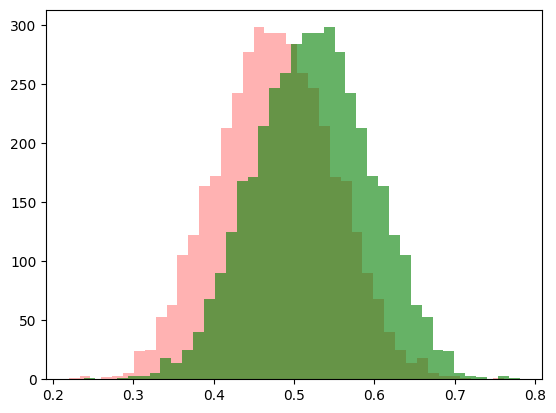

In [58]:
preds = logreg_model.predict(X_test)
probas = logreg_model.predict_proba(X_test)

plot_prob_hist(probas)
compare_results(preds, y_test, X_test)
print(classification_report(y_test, preds))

# Catboost

In [83]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=X_train.shape[1] // 10)
# pca.fit(X_train)

# X_train_pca = pca.transform(X_train)
# X_val_pca = pca.transform(X_val)
# X_test_pca = pca.transform(X_test)

In [87]:
from catboost import CatBoostClassifier


cbt_model = CatBoostClassifier(
                iterations=40_000,                
                learning_rate=3e-3,
                depth=3,
                task_type="GPU",
                devices='0',
                bootstrap_type='Poisson'
            )

cbt_model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
    plot=True,
    silent=True,
    use_best_model=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,preds,prob_dire,prob_radiant,X_test,y_test
0,1,0.376879,0.623121,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,0,0.583444,0.416556,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,1,0.427218,0.572782,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
5,1,0.275762,0.724238,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
7,1,0.425138,0.574862,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...,...,...,...
4079,1,0.366237,0.633763,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4084,1,0.435110,0.564890,"[0.531578947368421, 349.0, 0.5155277139522916,...",0
4085,1,0.421759,0.578241,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4087,0,0.582199,0.417801,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1


(1986, 2)


,y_pred,y_true
0,1,0
1,0,0
2,1,0
3,1,0
4,1,1
...,...,...
1981,1,1
1982,1,0
1983,1,1
1984,0,1


              precision    recall  f1-score   support

           0       0.55      0.33      0.41       934
           1       0.56      0.76      0.65      1052

    accuracy                           0.56      1986
   macro avg       0.56      0.55      0.53      1986
weighted avg       0.56      0.56      0.54      1986

Lost 0.515 samples


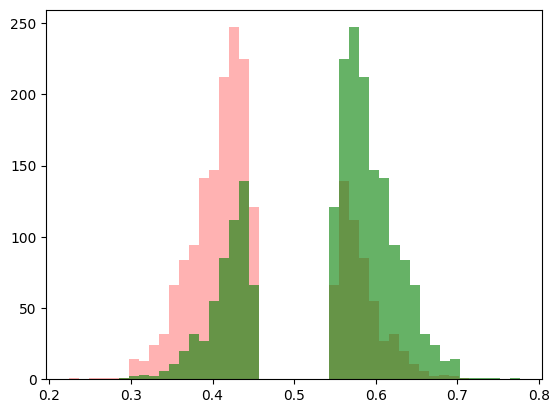

In [88]:
THRESHOLD = 0.55

df = pd.DataFrame()

preds = cbt_model.predict(X_test)
probas = cbt_model.predict_proba(X_test)

df['preds'] = preds.tolist()
df['prob_dire'] = probas[:, 0].tolist()
df['prob_radiant'] = probas[:, 1].tolist()
df['X_test'] = X_test.tolist()
df['y_test'] = y_test.tolist()

df_thr = df[(df['prob_dire'] > THRESHOLD) | (df['prob_radiant'] > THRESHOLD)]
display(df_thr)

probas_thr = np.concatenate(
    (
        df_thr['prob_dire'].to_numpy().reshape(-1, 1), 
        df_thr['prob_radiant'].to_numpy().reshape(-1, 1)
    ), axis=1)
print(probas_thr.shape)
preds_thr = df_thr['preds'].to_numpy()
X_test_thr = df_thr['X_test'].to_numpy()
y_test_thr = df_thr['y_test'].to_numpy()

plot_prob_hist(probas_thr)
compare_results(preds_thr, y_test_thr, X_test_thr)
print(classification_report(y_test_thr, preds_thr))
print(f'Lost {1 - df_thr.shape[0] / df.shape[0]:.3f} samples')

[1 0 0 ... 1 0 1]
[1 0 0 ... 1 0 1]


,y_pred,y_true
0,1,1
1,0,0
2,0,0
3,0,0
4,1,1
...,...,...
1977,1,1
1978,1,1
1979,1,1
1980,0,0


              precision    recall  f1-score   support

           0       0.90      0.92      0.91       946
           1       0.92      0.91      0.91      1036

    accuracy                           0.91      1982
   macro avg       0.91      0.91      0.91      1982
weighted avg       0.91      0.91      0.91      1982



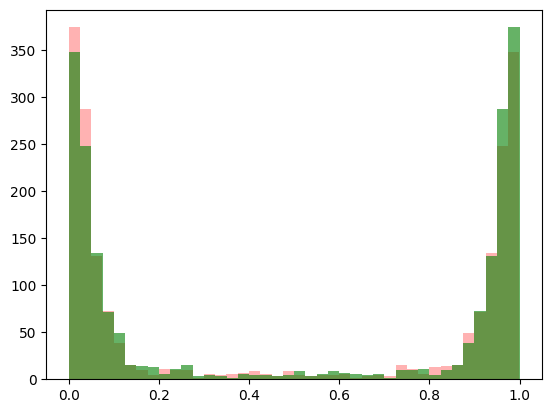

In [ ]:
preds = cbt_model.predict(X_val)
probas = cbt_model.predict_proba(X_val)

plot_prob_hist(probas)
compare_results(preds, y_val, X_val)
print(classification_report(y_val, preds))

In [15]:
model_name = 'HeroIds_0.91-F1.cbm'

cbt_model.save_model(
    fname='/Users/ankamenskiy/SmartDota/models/catboost/' + model_name,
    format="cbm"
)

In [33]:
import json
import sys
sys.path.append('../')

from lib.results_view import make_single_prediction

# print('LogReg:\n', make_single_prediction(logreg_model, 7599378829))
print('-'*50)
print('CatBoost:\n', make_single_prediction(cbt_model, 7599358486))

--------------------------------------------------
CatBoost:
 {'result': 'Radiant', 'dire': '0.28', 'radiant': '0.72'}
